# **Methylation Biomarkers for Predicting Cancer**

## **Dimensionality Reduction: Principal Component Anlaysis**

**Author:** Meg Hutch

**Date:** January 24, 2020

**Objective:** Use neural networks to classify colon, esophagus, liver, and stomach cancer patients and healthy subjects.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

Load Training and testing sets processed in R

In [2]:
# Training set
mcTrain = pd.read_csv('C:\\Users\\User\\Box Sync/Projects/Multi_Cancer_DL/02_Processed_Data/mcTrain.csv')
# Testing set
mcTest = pd.read_csv('C:\\Users\\User\\Box Sync/Projects/Multi_Cancer_DL/02_Processed_Data/mcTrain.csv')

**Data Pre-Processing**

Check if any missing values: Nope!

In [3]:
mcTest.columns[mcTest.isna().any()].tolist()
mcTrain.columns[mcTest.isna().any()].tolist()

[]

## **Principal Component Analysis**

We will first conduct dimensionality reduction using principal component analysis

First, subset the training set to only include the methylated gene information

In [4]:
# remove non-gene data from both the training and testing sets
genesTrain = mcTrain.drop(columns=["diagnosis", "dilute_library_concentration", "age", "gender"])

genesTest = mcTest.drop(columns=["diagnosis", "dilute_library_concentration", "age", "gender"])

Create patient seq_num id index

In [5]:
## Training set
# Convert patinet_ids to row names first
genesTrain = genesTrain.set_index(genesTrain.seq_num)

# Remove seq_num as a column
genesTrain = genesTrain.drop(columns=["seq_num"])

# Create a list of row names
patients = list(genesTrain.index)

## Testing set
# Convert patinet_ids to row names first
genesTest = genesTest.set_index(genesTest.seq_num)

# Remove seq_num as a column
genesTest = genesTest.drop(columns=["seq_num"])

# Create a list of row names
patientsTest = list(genesTest.index)

1) Standardize Dataset

Must scale features in your data before applying PCA. **StandardScaler** helps standardize features onto unit scale (mean = 0 and standard deviation = 1). Thus, each value in the dataset will have the sample mean value subtracted and then divided by the standard deviation of the whole dataset. 


In [8]:
# pca packages
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA

# convert integer type to float
cols = genesTrain.columns

#genesTrain[cols] = genesTrain[cols].astype(np.float)
#genesTest[cols] = genesTest[cols].astype(np.float)

# Stanardize/Scale the data
x = StandardScaler().fit_transform(genesTrain)
xTest = StandardScaler().fit_transform(genesTest)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


**Let's check whether the normalized data has a mean of zero and a standard deviation of 1**

In [9]:
np.mean(x), np.std(x)

(-7.303468988602816e-19, 0.9613744523838432)

**Convert the normalized features into tabular format**

In [10]:
# Create list of column names
features = list(genesTrain.columns.values) 

# Create data frame of newly normalized data - use patients IDs as the index 
x = pd.DataFrame(x, columns = features, index = patients)

2) Determine Prinicpal Components

Reference: https://stackoverflow.com/questions/42167907/understanding-scikitlearn-pca-transform-function-in-python

**pca.fit** allows PCA function to compute vectors that you can project your data onto in order to reduce the dimension of your data.

**pca.transform** actually performs the projection. It projects each row of data into the vector space that was learned when fit was called.

from sklearn: **fit_transform**: Fit the model with X and apply the dimensionality reduction on X

In [11]:
## Define pca function
pca = PCA()

# Fit to the scaled/standardized data - then use transform to prokect into the new vector space learned by fit
principalComponents = pca.fit_transform(x)

# Generate a list of column names with the number for each prinicpal component 
col_names = [f'pc{i}' for i in range(1, 239)] # there are 238 samples - so we want to have range of 1 less than 239 column names 

# Add column names to the principal component dataset 
principalDf = pd.DataFrame(principalComponents, columns = col_names, index = patients)

**3) Determine # of Components and Variance**

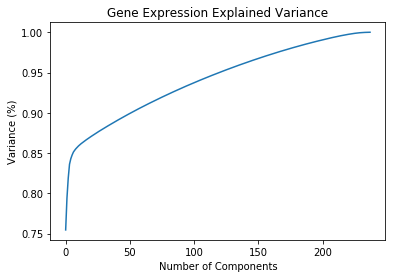

In [12]:
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Gene Expression Explained Variance')
plt.show()

**Alternative method - Pre-selecting % of variance**

When we fit the PCA classifier and transform x after specifying 90%, we get 52 principal components representing 90% of the variance.

In [13]:
pca = PCA(0.9)
x2 = pca.fit_transform(x)

x2 = pd.DataFrame(data = x2)
x2 

**Scree Plot**

View which principal components contribute most to the variance 

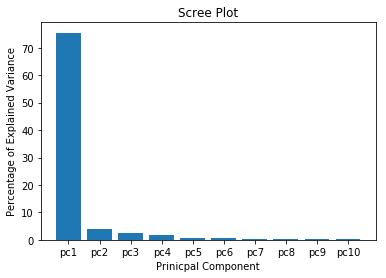

In [15]:
# remove PC from 
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
per_var = per_var[:10] #top 10 PC - this number is chosen just so that we can more easily view the plot
labels = col_names[:10]

plt.bar(x=range(1, len(per_var)+1), height = per_var, tick_label = labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Prinicpal Component')
plt.title('Scree Plot')
plt.show()

4) Project prinicipal components from the training set, to the test set

In [19]:
genesTest_transformed = pca.transform(genesTest)

When converted to a dataframe, we can see that the testset has been transformed into 52 principal components

In [18]:
genesTest_transformed = pd.DataFrame(data = genesTest_transformed)
genesTest_transformed

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,-115827.141412,-27177.365304,23890.422524,-10290.052469,-8103.003156,11732.829433,-4999.272392,-5605.288138,-14765.623057,-9861.049497,...,1994.475781,2422.268743,2450.633843,1978.966072,-2572.770699,-513.046162,338.643866,1474.699463,-6646.186936,4202.423643
1,-98362.168096,-17591.116818,23394.868489,-7833.157855,-9780.603544,13174.252395,-6939.738187,-3218.652483,-12899.462324,-8587.415204,...,1701.616555,2267.508519,1733.482188,1300.988658,-2524.079796,103.397157,197.952326,1578.752457,-5706.559925,3437.248767
2,-73569.439395,-10008.948789,16468.576429,-5845.966528,-2761.340048,7180.977993,-5114.137332,-2531.719357,-9740.887462,-6157.867776,...,1246.702531,1341.269413,1436.255119,1108.067121,-1839.939999,39.334841,327.163254,1038.699715,-4211.587519,2608.038850
3,-78011.146029,-19129.975318,17231.333304,-10321.428327,-6896.558343,8789.169125,-4745.953552,-3172.758683,-9307.726886,-6595.186051,...,1376.752990,1536.265688,1623.863254,1300.648559,-1855.762041,-179.130416,318.180741,1204.692175,-4449.938249,3043.101618
4,-81997.762236,-19656.989506,18093.159824,-9044.463256,-7568.762630,9489.588027,-5482.063036,-3198.314170,-10744.724468,-6594.786018,...,1531.733612,1837.434694,1725.909586,1593.211985,-1992.152509,-27.787973,115.302149,1192.281969,-4681.246135,2962.092586
5,-110347.603575,-24311.154020,24598.242056,-14062.387887,-7882.097119,11945.053089,-5327.755706,-4308.656814,-16384.734971,-9430.042928,...,1468.886851,2352.258308,1913.716816,1961.263860,-2485.419852,-103.956955,170.575997,1362.271275,-6567.179205,4101.231153
6,-65891.358732,-10531.914540,14825.616535,-7716.639294,-5368.279124,6805.587137,-3498.374342,-1627.653454,-8819.367675,-5503.626832,...,907.367563,1534.788763,1412.035081,1026.436817,-1672.214795,112.179031,221.844825,851.393364,-3573.749768,2427.658370
7,-99320.024684,-8035.175916,23000.412330,-1203.039902,-7739.924811,12994.068873,-5821.572942,-1643.985681,-13447.226818,-10360.870230,...,1832.601867,2510.717772,2051.795610,1501.308498,-2842.209064,849.456006,-47.028470,1550.325592,-5554.788566,3668.107451
8,-63275.429935,-12273.687657,16711.537998,-3717.370377,-6525.068632,7577.248147,-5998.251846,-1747.443161,-8325.374507,-5056.726980,...,1054.119041,1434.263293,1197.562503,1015.642871,-1447.067844,57.784680,111.899100,954.572526,-3453.801793,2405.266738
9,-96071.769242,-22366.523186,18054.433469,-11429.243880,-7720.582532,11144.089842,-8010.840211,-3343.450175,-12697.833289,-7903.427655,...,1645.885668,2010.400536,1939.426415,1656.115626,-2645.398096,-188.459542,569.388239,1307.173836,-5723.430522,3611.174114
